<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>




# Using Sentinel-3 for Ocean-Atmosphere Applications


Ocean-atmosphere applications are a challenging interdisciplinary space for scientific research and applications. They touch on many aspects of the Earth system including biogeochemical cycling, physical processes (mixing and transport) and complex ecosystem dynamics. 

Sentinel-3 provides data across ocean, atmosphere and land domains, from 3 instrument packages on the same platform...

## Ocean and Land Colour Instrument (OLCI)

The ocean and land colour instrument (OLCI) provides measurements of the light reflected by the oceans as well as a variety of derived geophysical products including chlorophyll-a and suspended matter concentrations.

OLCI also provides aerosol related products and will soon provide even more!

## Sea and Land Surface Temperature Radiometer (SLSTR)

The Sea and Land Surface Temperature Radiometer is used to provide sea surface temperature, aerosol, and fire products.

## Synthetic Aperture Radar Altimeter (SRAL and friends)

The Sentinel-3 mission provides altimetry measurements via a package of instruments centred around the Synthetic Aperture Radar Altimeter (SRAL). Products derived from the altimetry waveforms include sea surface height (and anomalies), significant wave height, and wind speed).

For detailed information on Sentinel-3 you can visit the <a href="https://eumetsatspace.atlassian.net/wiki/spaces/SEN3/overview">EUMETSAT user support knowledge base</a>.

This notebook is available at... in full executable form. Parts of the notebook are skipped in presentation mode for brevity.

In [1]:
%matplotlib inline

# standard and community libraries are imported here, 
# and we can import any library with an alias that allows us easy 
# access to them later.
import sys
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import glob
from IPython.core.display import display, HTML
import json
from zipfile import ZipFile
import warnings

# bespoke packages are installed here
import ocean_support_functions as osf


warnings.filterwarnings('ignore')


This notebook provides an overview of the data available from the Sentinel-3 mission that has relevance for a wide variety of applications in the domain of ocean-atmosphere interactions. Links are also provided to downstream added value and additional sources of data that is relevant for the applications of interest.

 - [1. Accessing Sentinel-3 from EUMETSAT](#s3_access)
 - [2. The carbon cycle](#carbon)
 - [3. Ocean Fertilisation](#fertilisation)
 - [4. Storm dynamics](#storms)
 - [5. Heat Fluxes](#heatflux)
 
 
 


### <a id='s3_access'></a>1. Accessing Sentinel-3 data from EUMETSAT

All examples here are available from EUMETSAT and via the WEkEO Data information and Access System. Code is provided to retrieve these images from the WEkEO Harmonised Data Access (HDA) API.  You can also explore data available through the WEkEO data viewer.

<br>

<div style='text-align:center;'>
<figure><img src='./img/wekeo_data_search2.png' width='70%' />
    <figcaption><i>WEkEO interface to search for datasets</i></figcaption>
</figure>
</div>



You can also access the data through the graphical user interfaces available through the <a href="https://coda.eumetsat.int">EUMETSAT Copernicus Online Data Access (CODA)</a>.

Watch the videos on our YouTube Channel for accessing CODA... [![CODA OLCI VIDEO](http://img.youtube.com/vi/V3NAuafvlFM/0.jpg)](http://www.youtube.com/watch?v=V3NAuafvlFM "Click to watch a video tutorial on using CODA") 
...or use the API with some example Python code available on the <a href="https://gitlab.eumetsat.int/eumetlab/cross-cutting-tools/sentinel-downloader">EUMETSAT Gitlab</a>

In [ ]:
# Download example files using WEkEO HDA - see examples on https://github.com/wekeo/wekeo-jupyter-lab for detailed explanation

# your WEkEO API username and password (needs to be in '  ')
user_name = 'USERNAME'
password = 'PASSWORD'

# Generate an API key
api_key = hapi.generate_api_key(user_name, password)
display(HTML('Your API key is: <b>'+api_key+'</b>'))

# set this key to true to download data.
download_data = True

### <a id='carbon'></a>2. The carbon cycle

The carbon cycle is a major area of interest in ocean-atmosphere interactions, given anthropegenic climate change and the connection to oceanic food webs. 

Satellite data can provide insights to various components of this complex system. From the marine perspective, Sentinel-3 OLCI provides:
- Reflectance data
- Derived products (chlorophyll-a, IOPS, TSM)

These can be useful for:
- Understanding phytoplankton and sediment dynamics
- Estimating ocean carbon cycle parameters, such as POC


In [2]:
# global settings (extents roughly removes the 'invalid' borders on the edge of an OLCI scene)
fsz = 20
plt.rc('font', size=fsz)
dpi = 150
subset_extents = [0,-1,150,-100]

In [3]:
# set paths
DATA_PATHS = [os.path.join(os.getcwd(),'Support_data',
              'S3A_OL_1_EFR____20210717T101015_20210717T101315_20210718T145224_0179_074_122_1980_MAR_O_NT_002.SEN3'),
              os.path.join(os.getcwd(),'Support_data',
              'S3A_OL_2_WFR____20210717T101015_20210717T101315_20210718T221347_0179_074_122_1980_MAR_O_NT_003.SEN3')]


# read L1 data
lon, lat, red_L1, green_L1, blue_L1, rlon, rlat = osf.get_OLCI_RGB(DATA_PATHS[0],
                                         run_reduce_image=True,
                                         rgb_recipe='3_channel',
                                         run_subset_image=True,
                                         subset_extents = subset_extents,
                                         return_orig_coords=True)

# prep L1 image
image_array_L1, colorTuple_L1, lon, lat = osf.process_image(lon, lat, red_L1, green_L1, blue_L1,
                                          run_truncate_image=True,
                                          contrast=[1.2,1.0,1.0],
                                          unhitch=True,
                                          run_histogram_image=True)

# read L2 data
ds1 = xr.open_dataset(os.path.join(DATA_PATHS[1],'chl_nn.nc'))       
CHL_NN = ds1.CHL_NN.data
ds1.close()

# prep L2 data
ds1 = xr.open_dataset(os.path.join(DATA_PATHS[1],'wqsf.nc'))
# get all the flag names
flag_names = ds1.WQSF.flag_meanings.split(' ')
# get all the flag bit values
flag_vals = ds1.WQSF.flag_masks
# get the flag field itself
FLAGS = ds1.WQSF.data
ds1.close()

# NN standard flags
flags_we_want = ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED',
                 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'OCNN_FAIL']
flag_mask_nn = osf.flag_data_fast(flags_we_want, flag_names, flag_vals, FLAGS, flag_type='WQSF')
flag_mask_nn = flag_mask_nn.astype(float)
flag_mask_nn[flag_mask_nn == 0.0] = np.nan
CHL_NN[np.isfinite(flag_mask_nn)] = np.nan
CHL_NN = CHL_NN[subset_extents[0]:subset_extents[1],subset_extents[2]:subset_extents[3]]
CHL_NN = osf.reduce_image(CHL_NN,5)

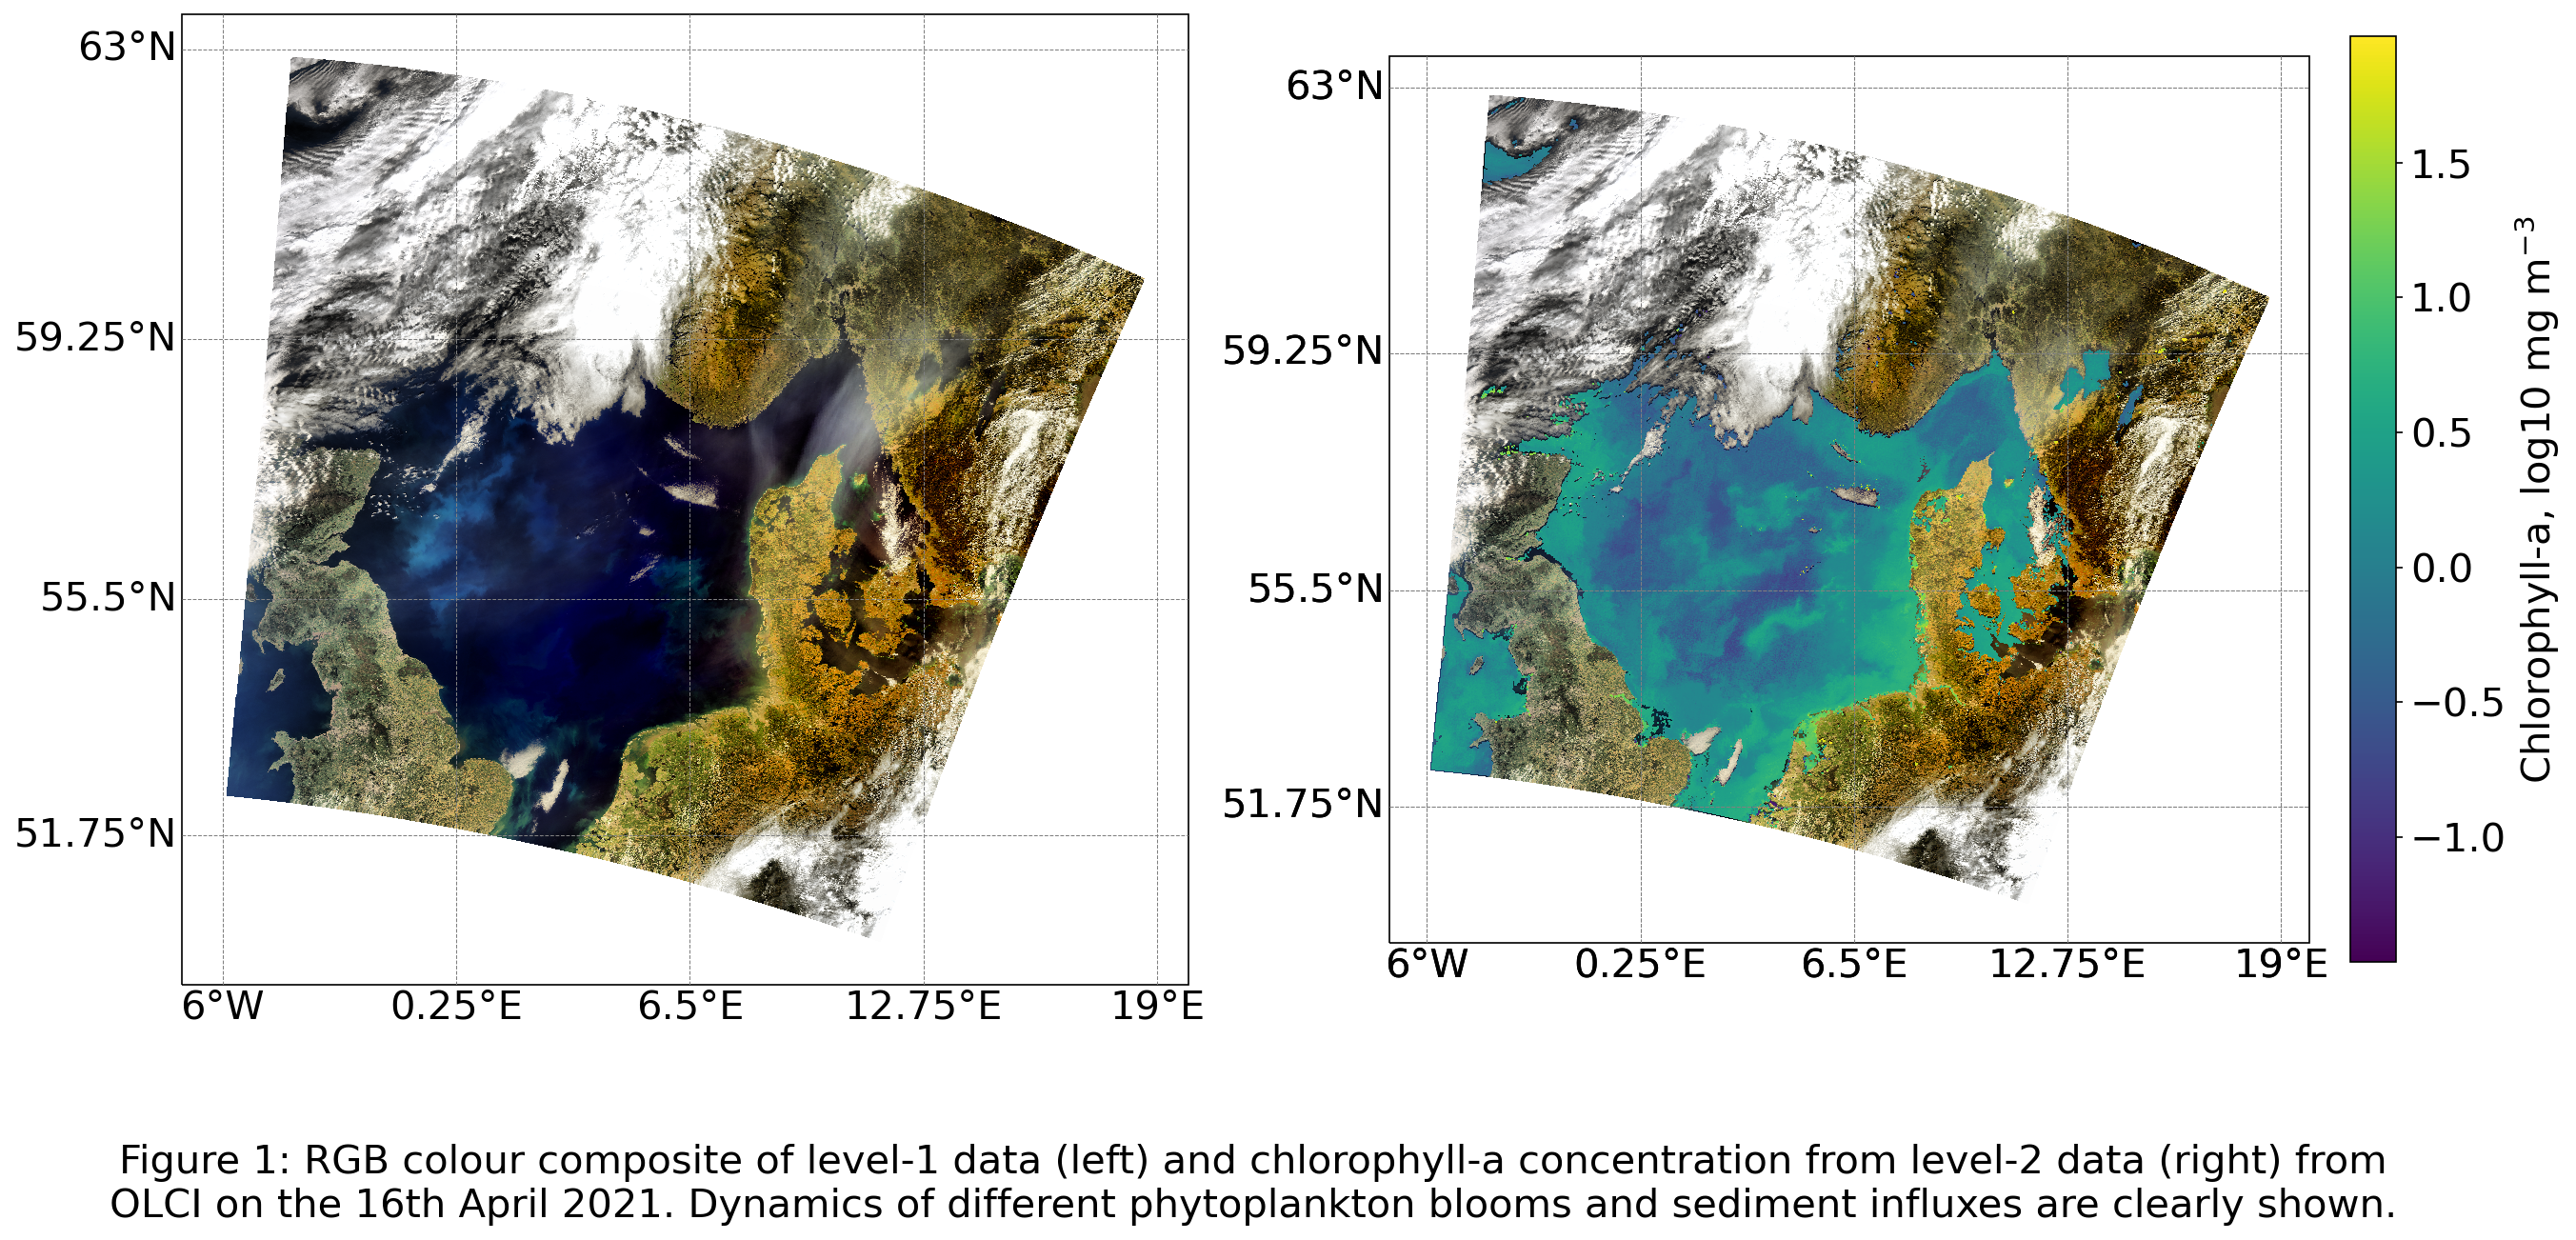

In [4]:
# initialise a figure
fig1 = plt.figure(figsize=(20, 10), dpi=dpi)
gs = gridspec.GridSpec(1, 2)

# make an axis and plot
m = plt.subplot(gs[0,0], projection=ccrs.Mercator())
p1 = osf.plot_scene(m, lon, lat, lon, RGB_plot=True, \
     colorTuple=colorTuple_L1, fsz=fsz)

# make an axis
m = plt.subplot(gs[0,1], projection=ccrs.Mercator())
p1 = osf.plot_scene(m, lon, lat, lon, RGB_plot=True, \
     colorTuple=colorTuple_L1, fsz=fsz)
p1 = osf.plot_scene(m, lon, lat, CHL_NN, fsz=fsz)
cbar = plt.colorbar(p1, orientation="vertical", fraction=0.046, pad=0.04) 
cbar.set_label('Chlorophyll-a, log10 mg m$^{-3}$', fontsize=20)

# add caption
fig1.text(0.5, 0.0, r'Figure 1: RGB colour composite of level-1 data (left) and chlorophyll-a concentration from level-2 data (right) from'+'\n'+ 
          'OLCI on the 16th April 2021. Dynamics of different phytoplankton blooms and sediment influxes are clearly shown.',\
          ha='center', fontsize=20)
plt.show()

### <a id='fertilisation'></a>3. Ocean Fertilisation

Atmospheric deposition from a variety of sources (dust, volcanic eruptions etc), can act as nutrient input, driving phytoplankton blooms in different parts of the ocean. Sentinel-3 can provide data on both atmopsheric and ocean sides of this phenomena.



In [5]:
# set paths
DATA_PATHS = [os.path.join(os.getcwd(),'Support_data',
              'S3B_OL_1_EFR____20191221T230343_20191221T230643_20191230T075705_0179_033_272_3420_MAR_O_NT_002.SEN3')]

subset_extents = [0,-1,150,-100]

# read L1 data
lon, lat, red_L1, green_L1, blue_L1, rlon, rlat = osf.get_OLCI_RGB(DATA_PATHS[0],
                                         run_reduce_image=True,
                                         rgb_recipe='3_channel',
                                         run_subset_image=True,
                                         subset_extents = subset_extents,
                                         return_orig_coords=True)

# prep L1 image
image_array_L1, colorTuple_L1, lon, lat = osf.process_image(lon, lat, red_L1, green_L1, blue_L1,
                                          run_truncate_image=True,
                                          contrast=[1.2,1.0,1.0],
                                          unhitch=True,
                                          run_histogram_image=True)

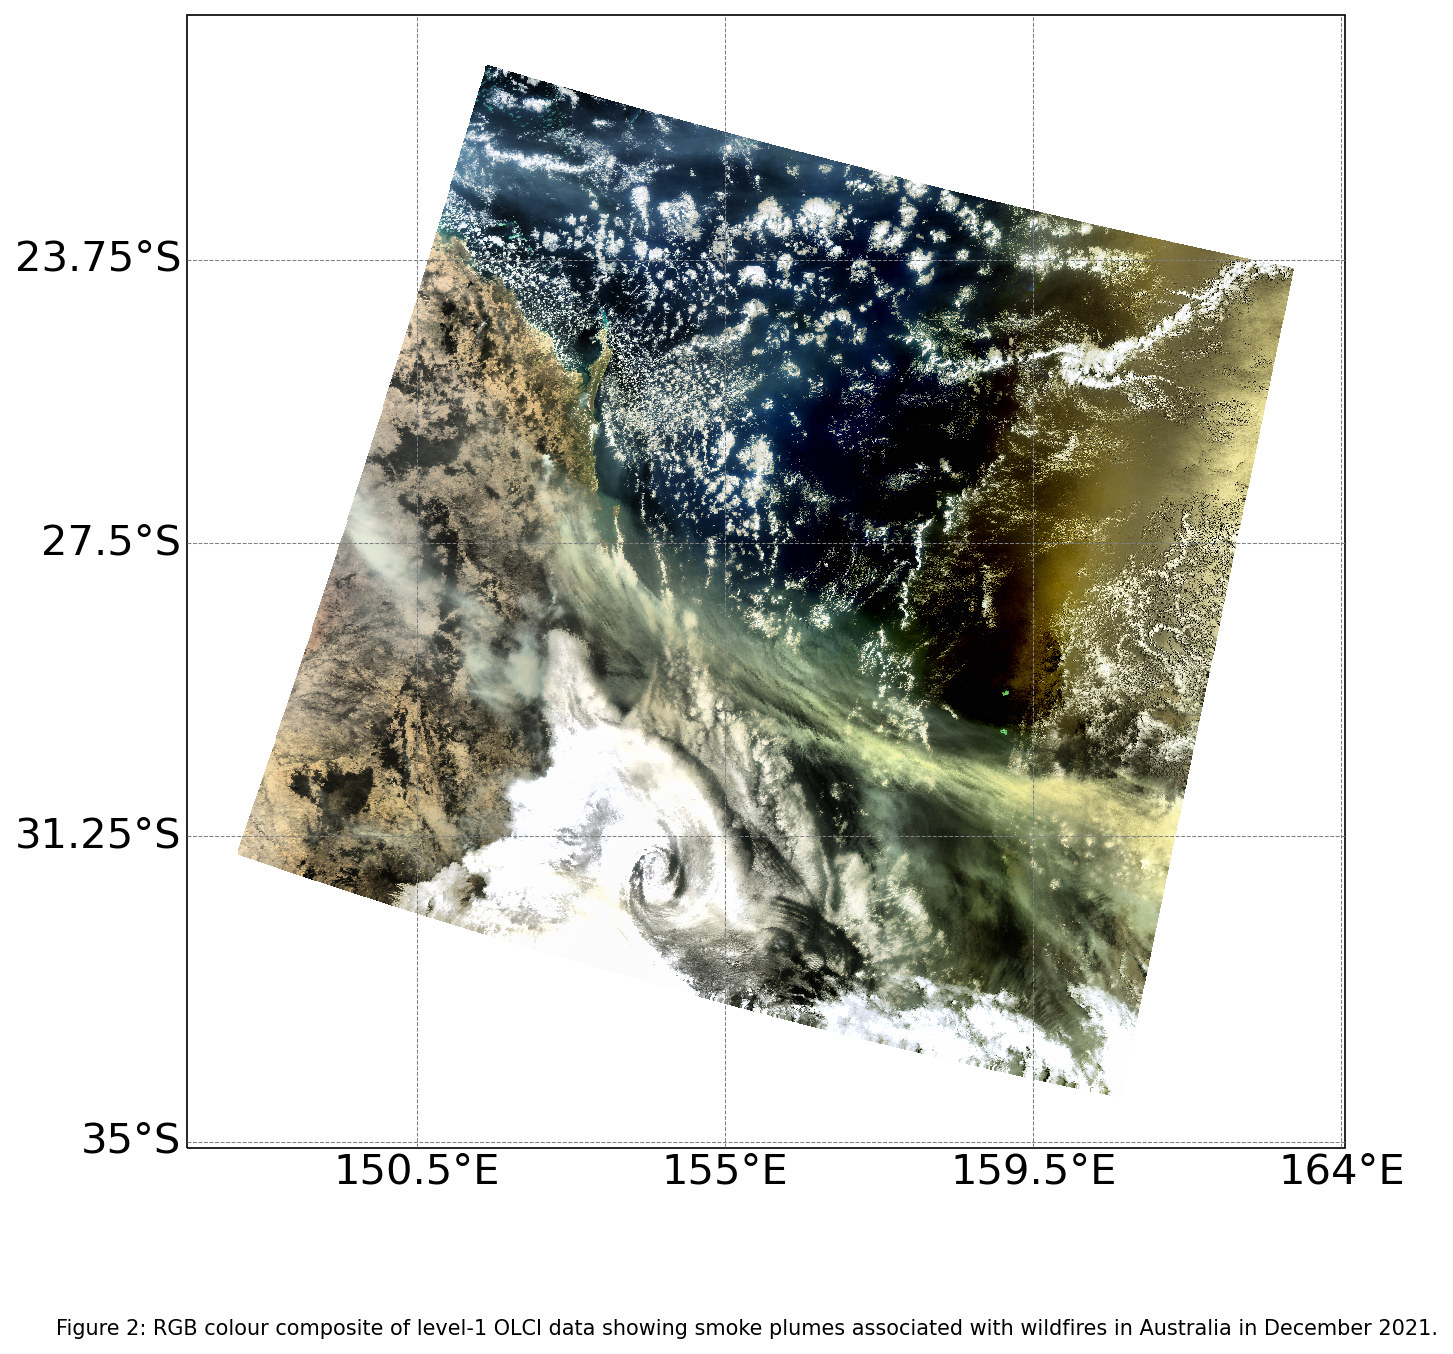

In [6]:
# initialise a figure
fig1 = plt.figure(figsize=(10, 10), dpi=dpi)
gs = gridspec.GridSpec(1, 1)

# make an axis and plot
m = plt.subplot(gs[0,0], projection=ccrs.Mercator())
p1 = osf.plot_scene(m, lon, lat, lon, RGB_plot=True, \
     colorTuple=colorTuple_L1, fsz=fsz)

# add caption
fig1.text(0.5, 0.0, r'Figure 2: RGB colour composite of level-1 OLCI data showing smoke plumes associated with wildfires in Australia in December 2021.',\
          ha='center', fontsize=10)
plt.show()

Users can work with data records such as those available from CMEMS that integrate Sentinel-3 data with other satellite records, to attribute and investigate the long-term consequences of such events. 

### <a id='storms'></a>4. Storm Dynamics

A major event in terms of ocean-atmosphere interactions, storms can be well observed using the suite of instruments aboard Sentinel-3. In particular the combination of synchronous visible imagery, SST, and altimetry derived measurements of sea surface height, wind speed, and significant wave height, provide a comprehensive picture of storms. 

<br>

<div style='text-align:center;'>
<figure><img src='./img/SSHA_SWH_map1.png' width='70%' />
    <figcaption><i>Figure 3: SLSTR and SRAL data over Hurricane Dorian...</i></figcaption>
</figure>
</div>


### <a id='heatflux'></a>5. Heat Flux

The flux of heat between the ocean and atmosphere represents a major application of satellite data.

Amongst the products necessary for estimating heat fluxes, Sentinel-3 can provide data on sea surface temperature. 

In [7]:
DATA_PATHS = [os.path.join(os.getcwd(),'Support_data',
              'S3A_SL_2_WST____20210515T012041_20210515T030140_20210516T115746_6059_071_373______MAR_O_NT_003.SEN3')]
subset_extents = [-66.75,-56.5,37,43.5]
quality_max = 4

# read L2 data
ds1 = xr.open_dataset(os.path.join(DATA_PATHS[0],'20210515012041-MAR-L2P_GHRSST-SSTskin-SLSTRA-20210516115746-v02.0-fv01.0.nc'))       
SST = ds1.sea_surface_temperature.data
QL = ds1.quality_level.data
SST[QL < quality_max] = np.nan
SST_bias = ds1.sses_bias.data
SST_bias_corr = np.squeeze(SST + SST_bias)
lon = ds1.lon.data
lat = ds1.lat.data
ds1.close()

i1, i2, j1, j2 = osf.subset_image(lat, lon, subset_extents)
lon = lon[i1:i2,j1:j2]
lat = lat[i1:i2,j1:j2]
SST_bias_corr = SST_bias_corr[i1:i2,j1:j2]

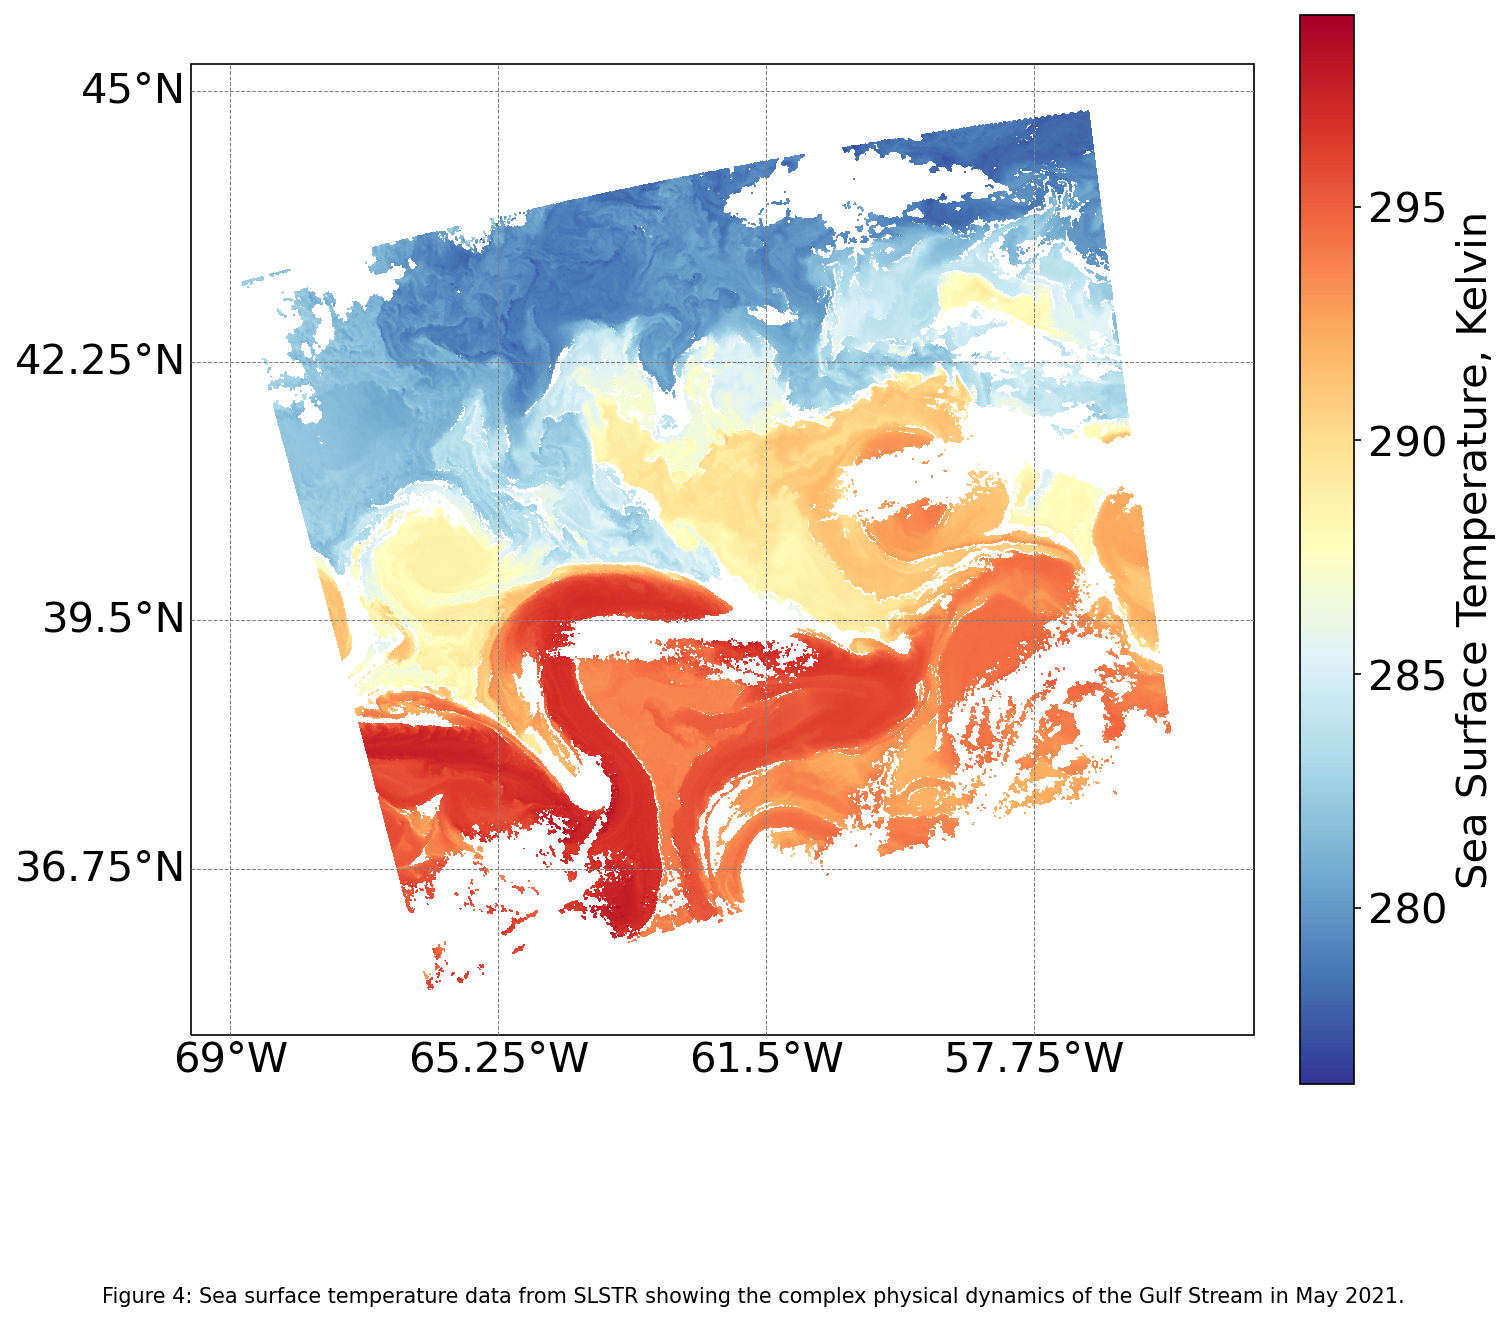

In [8]:
# initialise a figure
fig1 = plt.figure(figsize=(10, 10), dpi=dpi)
gs = gridspec.GridSpec(1, 1)

# make an axis and plot
m = plt.subplot(gs[0,0], projection=ccrs.Mercator())
p1 = osf.plot_scene(m, lon, lat, SST_bias_corr, fsz=fsz, cmap=plt.cm.RdYlBu_r)
cbar = plt.colorbar(p1, orientation="vertical", fraction=0.046, pad=0.04) 
cbar.set_label('Sea Surface Temperature, Kelvin', fontsize=20)

# add caption
fig1.text(0.5, 0.0, r'Figure 4: Sea surface temperature data from SLSTR showing the complex physical dynamics of the Gulf Stream in May 2021.',\
          ha='center', fontsize=10)
plt.show()

Sentinel-3 SST data, along with that from other EUMETSAT missions, contributes to long-term SST records from CMEMS and OSI-SAF that are highly relevant of understanding heat flux.

## Further support on Sentinel-3 data

- View our knowledge base
- Contact our helpdesk
- Attend specific training events using the data


    
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>